# Exploratory Data Analysis

This notebook presents a structured exploration of retail supply chain sales data that has been thoroughly cleaned and prepared for analysis.

The objective of this EDA is to uncover meaningful insights across four critical business questions:\**a. How can we forecast retail sales more effectively?\
b. What is the relationship between profitability and discount strategies?\
c. How do customer segments differ in terms of sales and profitability?\
d. What patterns emerge in product returns across categories and regions?**

By examining these areas, the analysis aims to highlight trends, risks, and opportunities that can inform data-driven decision-making in retail operations.


In [1]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style = "whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [2]:
# Load the cleaning data
sales = pd.read_csv("../data/cleaned/sales_clean.csv")
time_dim = pd.read_csv("../data/cleaned/time_dimension.csv")

print("Sales dataset:", sales.shape)
print("Time dimension dataset:", time_dim.shape)

Sales dataset: (9994, 23)
Time dimension dataset: (1826, 13)


In [3]:
# Quick overview
print(sales.info())
print(sales.describe())
print(sales.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Row ID               9994 non-null   int64  
 1   Order ID             9994 non-null   object 
 2   Order Date           9994 non-null   object 
 3   Ship Date            9994 non-null   object 
 4   Ship Mode            9994 non-null   object 
 5   Customer ID          9994 non-null   object 
 6   Customer Name        9994 non-null   object 
 7   Segment              9994 non-null   object 
 8   Country              9994 non-null   object 
 9   City                 9994 non-null   object 
 10  State                9994 non-null   object 
 11  Postal Code          9994 non-null   int64  
 12  Region               9994 non-null   object 
 13  Retail Sales People  9994 non-null   object 
 14  Product ID           9994 non-null   object 
 15  Category             9994 non-null   o

## 1. Data Preparation (Re-check Cleaning in EDA)

In [4]:
# Convert 'date' columns
sales["Order Date"] = pd.to_datetime(sales["Order Date"], errors="coerce")
sales["Ship Date"] = pd.to_datetime(sales["Ship Date"], errors="coerce")
time_dim["Date"] = pd.to_datetime(time_dim["Date"], errors="coerce")

In [5]:
# Validate ship date >= order date
invalid_ship = sales[sales["Ship Date"] < sales["Order Date"]]
print("Invalid ship dates:", invalid_ship.shape)

Invalid ship dates: (0, 23)


In [6]:
# Normalize discount (0–1)
sales.loc[sales["Discount"] > 1, "Discount"] = sales["Discount"] / 100.0

In [7]:
# Handle missing values
if "Postal Code" in sales.columns:
    sales["Postal Code"] = sales["Postal Code"].fillna(0)
if "Returned" in sales.columns:
    sales["Returned"] = sales["Returned"].fillna("No")

In [8]:
# Standardize categorical columns
for col in ["Segment","Category","Region","Ship Mode"]:
    if col in sales.columns:
        sales[col] = sales[col].astype(str).str.strip().str.title()

In [9]:
# Drop duplicates
sales = sales.drop_duplicates()

In [10]:
# Supporting dataset consistency check
time_dim["Year_check"] = time_dim["Date"].dt.year
time_dim["Month_check"] = time_dim["Date"].dt.month
time_dim["Day_check"] = time_dim["Date"].dt.day

mismatches = time_dim[(time_dim["Year"] != time_dim["Year_check"]) |
                      (time_dim["Month"] != time_dim["Month_check"]) |
                      (time_dim["Day"] != time_dim["Day_check"])]

print("Mismatches in time dimension:", mismatches.shape)

time_dim = time_dim.drop(columns=["Year_check","Month_check","Day_check"]).drop_duplicates()

print("Sales dataset after re-clean:", sales.shape)
print("Time dimension dataset after re-clean:", time_dim.shape)

Mismatches in time dimension: (0, 16)
Sales dataset after re-clean: (9994, 23)
Time dimension dataset after re-clean: (1826, 13)


## 2. Forecasting Retail Sales

In [12]:
# Merge by time dimension
sales_time = sales.merge(time_dim, left_on="Order Date", right_on="Date", how="left")

In [13]:
# Monthly sales aggregation
monthly_sales = sales_time.groupby(["Year","Month"])["Sales"].sum().reset_index()
monthly_sales["YearMonth"] = pd.to_datetime(monthly_sales[["Year","Month"]].assign(DAY=1))

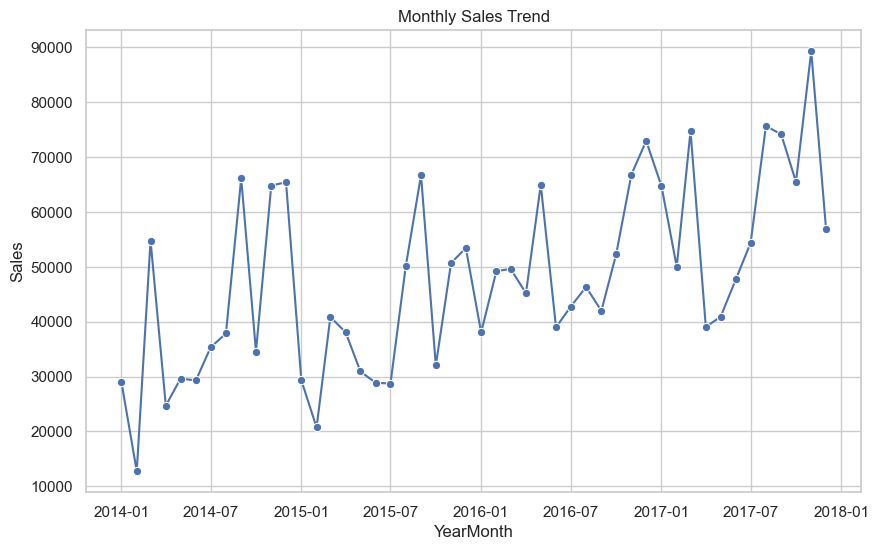

In [14]:
# Line chart monthly sales trend
sns.lineplot(data=monthly_sales, x="YearMonth", y="Sales", marker="o")
plt.title("Monthly Sales Trend")
plt.show()

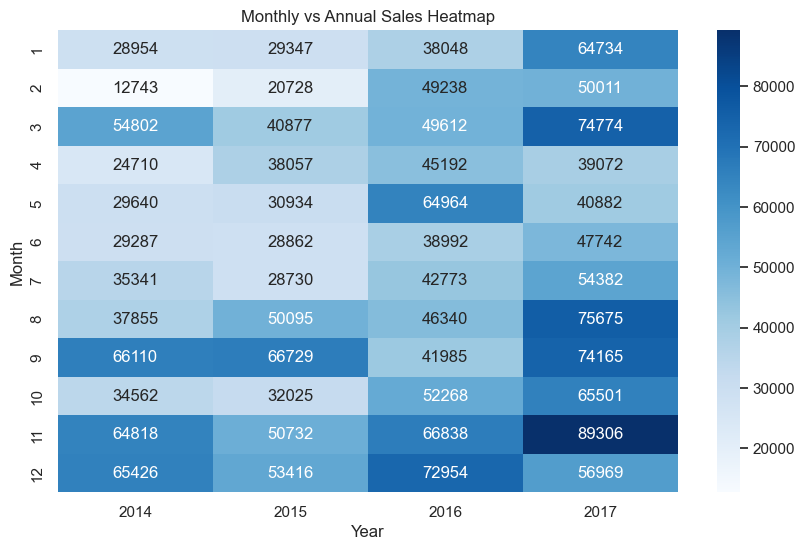

In [16]:
# Seasonal heatmap
pivot = monthly_sales.pivot(index="Month", columns="Year", values="Sales")
sns.heatmap(pivot, cmap="Blues", annot=True, fmt=".0f")
plt.title("Monthly vs Annual Sales Heatmap")
plt.show()

## 3. Profitability vs Discounts

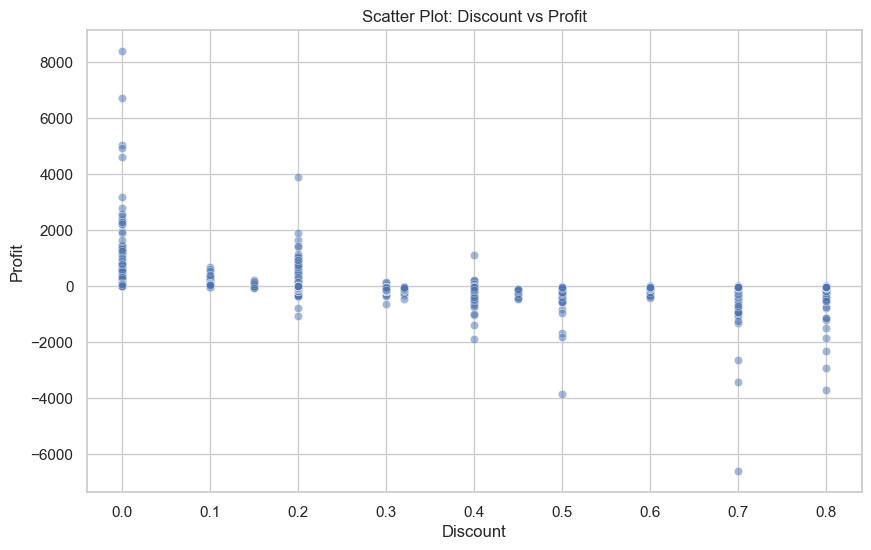

In [17]:
sns.scatterplot(data=sales, x="Discount", y="Profit", alpha=0.5)
plt.title("Scatter Plot: Discount vs Profit")
plt.show()

In [18]:
# Correlations
print("Correlation Discount-Profit:\n", sales[["Discount","Profit"]].corr())

Correlation Discount-Profit:
           Discount    Profit
Discount  1.000000 -0.219487
Profit   -0.219487  1.000000


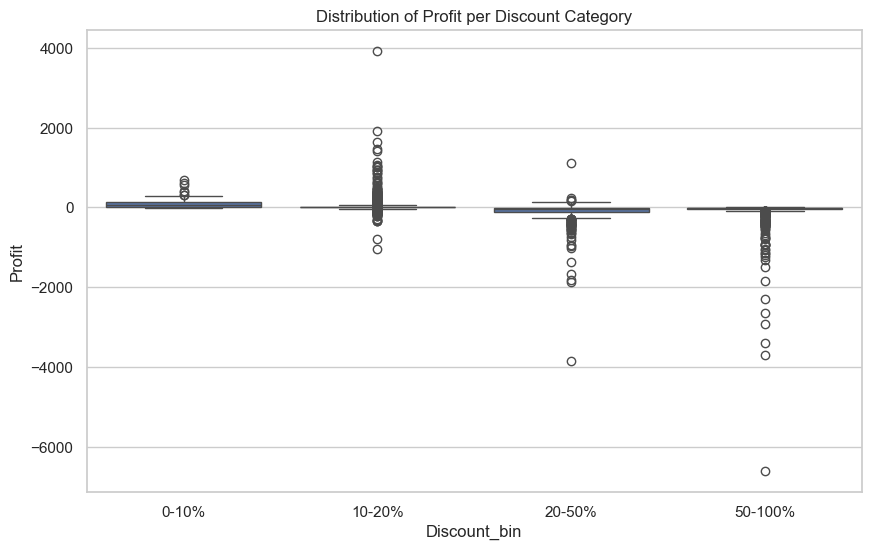

In [19]:
# Boxplot of profit per discount category
sales["Discount_bin"] = pd.cut(sales["Discount"], bins=[0,0.1,0.2,0.5,1],
                               labels=["0-10%","10-20%","20-50%","50-100%"])
sns.boxplot(data=sales, x="Discount_bin", y="Profit")
plt.title("Distribution of Profit per Discount Category")
plt.show()

## 4. Customer Segmentation

In [20]:
seg_summary = sales.groupby("Segment").agg({
    "Sales":"sum",
    "Profit":"sum",
    "Discount":"mean"
}).reset_index()
print(seg_summary)

       Segment         Sales       Profit  Discount
0     Consumer  1.161401e+06  134119.2092  0.158141
1    Corporate  7.061464e+05   91979.1340  0.158228
2  Home Office  4.296531e+05   60298.6785  0.147128


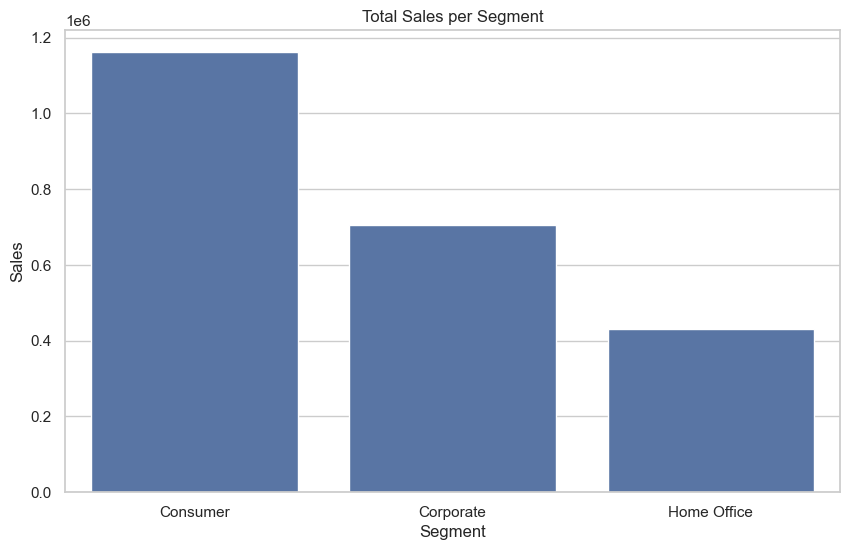

In [21]:
sns.barplot(data=seg_summary, x="Segment", y="Sales")
plt.title("Total Sales per Segment")
plt.show()

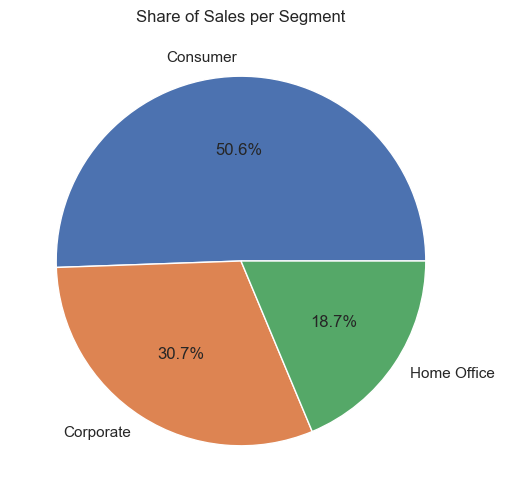

In [22]:
plt.pie(seg_summary["Sales"], labels=seg_summary["Segment"], autopct="%1.1f%%")
plt.title("Share of Sales per Segment")
plt.show()

## 5. Return Analysis

In [23]:
if "Returned" in sales.columns:
    return_rate = sales.groupby("Category")["Returned"].apply(lambda x: (x=="Yes").mean()).reset_index()
    return_rate.rename(columns={"Returned":"ReturnRate"}, inplace=True)
    print(return_rate)

          Category  ReturnRate
0        Furniture    0.080622
1  Office Supplies    0.078493
2       Technology    0.084461


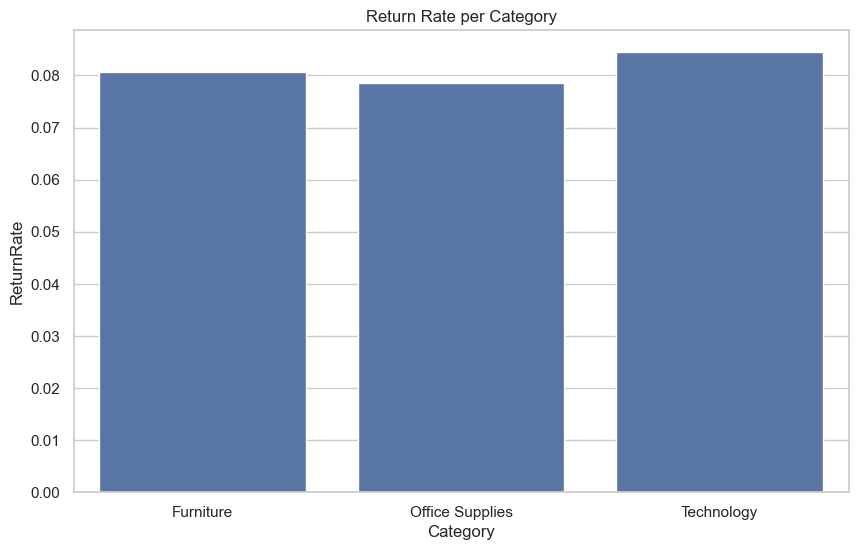

In [25]:
sns.barplot(data=return_rate, x="Category", y="ReturnRate")
plt.title("Return Rate per Category")
plt.show()

Returned       Not       Yes
Region                      
Central   0.960396  0.039604
East      0.947683  0.052317
South     0.957407  0.042593
West      0.847018  0.152982


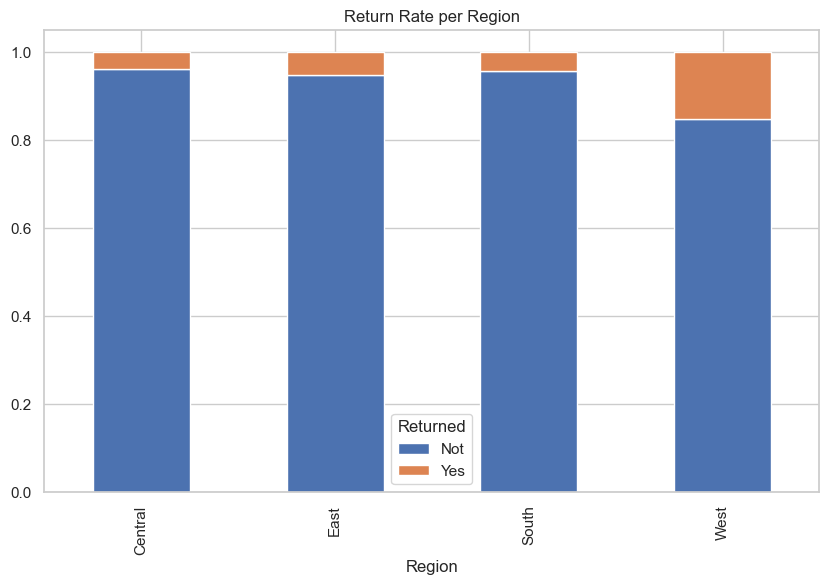

In [26]:
# Crosstab return per region
if "Region" in sales.columns:
        crosstab = pd.crosstab(sales["Region"], sales["Returned"], normalize="index")
        print(crosstab)
        crosstab.plot(kind="bar", stacked=True)
        plt.title("Return Rate per Region")
        plt.show()

## 6. Quality Check

In [33]:
print("Missing values:\n", sales.isnull().sum())

Missing values:
 Row ID                 0
Order ID               0
Order Date             0
Ship Date              0
Ship Mode              0
Customer ID            0
Customer Name          0
Segment                0
Country                0
City                   0
State                  0
Postal Code            0
Region                 0
Retail Sales People    0
Product ID             0
Category               0
Sub-Category           0
Product Name           0
Returned               0
Sales                  0
Quantity               0
Discount               0
Profit                 0
Discount_bin           0
dtype: int64


In [32]:
sales = sales.dropna(subset=["Discount_bin"])

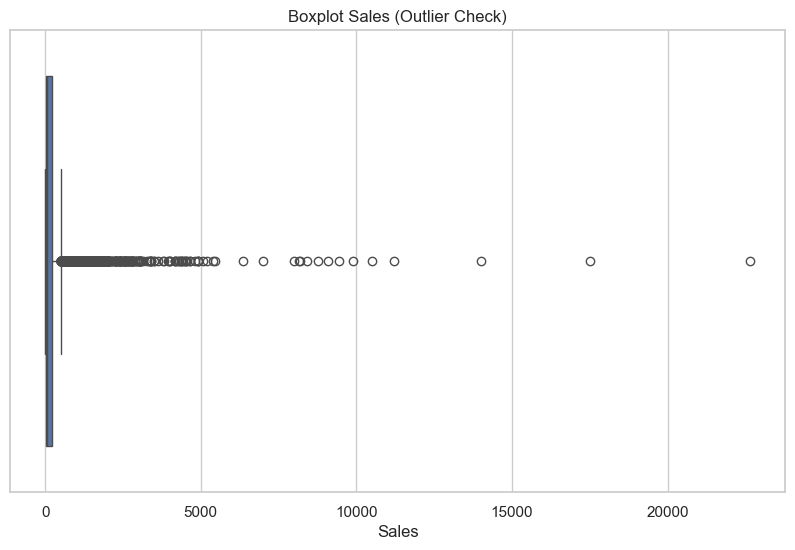

In [28]:
sns.boxplot(data=sales, x="Sales")
plt.title("Boxplot Sales (Outlier Check)")
plt.show()

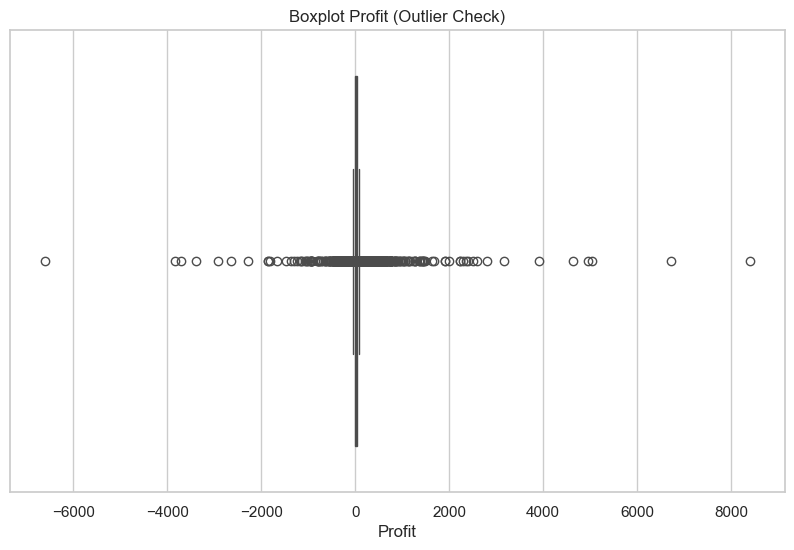

In [29]:
sns.boxplot(data=sales, x="Profit")
plt.title("Boxplot Profit (Outlier Check)")
plt.show()

In [30]:
invalid_ship = sales[sales["Ship Date"] < sales["Order Date"]]
print("Invalid ship dates:", invalid_ship.shape)

Invalid ship dates: (0, 24)


# Key Insights from Exploratory Data Analysis

The exploratory analysis of retail supply chain sales data has revealed several important patterns:

- **Sales Trends**: Monthly sales show clear seasonality with recurring peaks and an overall upward trajectory across the years.  
- **Seasonality by Year**: The heatmap highlights consistent high-sales months, with notable year-to-year variations that emphasize the importance of seasonal forecasting.  
- **Discount Impact**: Both scatter and boxplot analyses confirm that higher discount levels are strongly associated with declining profitability, with extreme discounts often leading to losses.  
- **Customer Segments**: The Consumer segment contributes more than half of total sales, while Corporate and Home Office segments represent smaller but significant shares, offering potential for targeted growth strategies.  
- **Returns Analysis**: Return rates vary across categories and regions. Technology products and the Western region show the highest return rates, signaling areas for operational review and quality improvement.  
- **Outlier Analysis**: Boxplot checks reveal significant outliers in both Sales and Profit distributions. Sales outliers represent unusually large transactions, while Profit outliers extend in both positive and negative directions. These extremes highlight the need for robust statistical treatment and careful modeling to avoid skewed insights.  

Overall, the dataset is clean, reliable, and provides a strong foundation for advanced modeling. These insights establish a clear narrative: sales are growing but highly seasonal, discount strategies must be carefully managed, customer segmentation offers opportunities for tailored approaches, and returns highlight operational challenges. Outlier detection further strengthens the case for cautious, data-driven decision making. This EDA sets the stage for deeper forecasting, segmentation, and profitability optimization to drive data-informed retail strategy.